In [ ]:
!apt-get update
!sudo apt-get install python3-opencv

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,082 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,270 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,005 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,347 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpa

In [ ]:
!python3 --version

Python 3.10.12


In [ ]:
!nvidia-smi

Tue Oct 17 14:52:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Montar la unidad Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# mover el archivo data.sip
import shutil

# Ruta del archivo original
source_file_path = '/content/drive/MyDrive/data.zip'

# Ruta de destino para mover el archivo
destination_folder_path = '/content/'

# Mueve el archivo a la nueva ubicación
shutil.move(source_file_path, destination_folder_path)

'/content/data.zip'

In [ ]:
import zipfile

# Ruta del archivo ZIP a descomprimir
zip_file_path = '/content/data.zip'

# Ruta de destino para extraer el contenido del archivo ZIP
destination_folder_path = '/content/'

# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder_path)

In [ ]:
!pwd
!ls

/content
data  data.zip	drive  sample_data


In [ ]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from torchvision import utils

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
# Define la clase de dataset personalizado
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"JPEGImages"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
        self.class_dict = {'Motorbike': 1, 'background': 0}

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self,idx):
        img_path = os.path.join(self.root,"JPEGImages",self.imgs[idx])
        annotations_path = os.path.join(self.root,"Annotations",self.annotations[idx])
        img = cv2.imread(img_path)
        annotation = self.parse_annotation(annotations_path)

        for obj in annotation['objects']:
            obj['xmin'] = int(obj['xmin'])
            obj['xmax'] = int(obj['xmax'])
            obj['ymin'] = int(obj['ymin'])
            obj['ymax'] = int(obj['ymax'])

        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transforms is not None:
            img = self.transforms(img)

        boxes = []
        labels = []

        for obj in annotation['objects']:
            boxes.append([obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']])
            labels.append(self.class_dict[obj['name']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        return  img, boxes, labels

    def parse_annotation(self,annotations_path):
        tree = ET.parse(annotations_path)
        root = tree.getroot()

        objects = []

        for obj in root.findall('object'):
            obj_dict = {}
            obj_dict['name'] = obj.find('name').text
            obj_dict['xmin'] = int(obj.find('bndbox/xmin').text)
            obj_dict['ymin'] = int(obj.find('bndbox/ymin').text)
            obj_dict['xmax'] = int(obj.find('bndbox/xmax').text)
            obj_dict['ymax'] = int(obj.find('bndbox/ymax').text)
            objects.append(obj_dict)

        return {
            'objects': objects
        }

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
root = "data"
dataset = CustomDataset(root,transform)

tamaño de los datos 9220

tensor([[363., 296., 414., 368.]])
tensor([1])
torch.Size([3, 720, 1280])
0.9137255


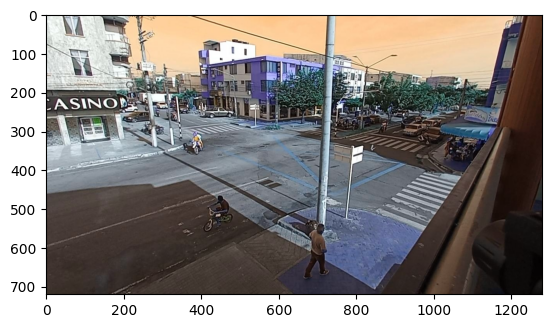

363 296 414 368


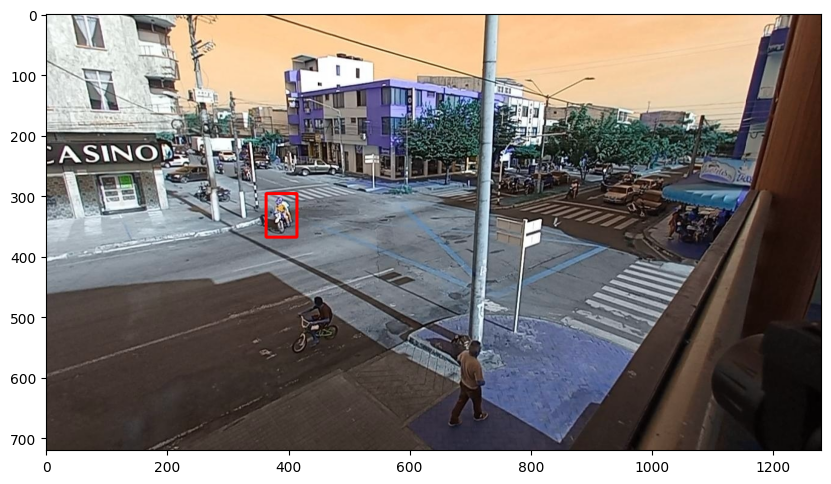

In [ ]:
idx = 30

imagen, boxes , labels = dataset[idx]
# explorando los datos
print("tamaño de los datos", len(dataset))
print("")


# dato de los boxes
print(boxes)
print(labels)
print(imagen.shape)

# Mostrar la imagen
img = imagen.permute(1,2,0).numpy()
print(img[0][0][0])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

#
minimo = np.min(img)
maximo = np.max(img)

img = 255/(maximo-minimo)*(img-minimo)
img = np.array(img,dtype=np.uint8)

plt.imshow(img)
plt.show()


for coor in boxes:
    xmin = int(coor[0])
    ymin = int(coor[1])
    xmax = int(coor[2])
    ymax = int(coor[3])
    print(xmin,ymin,xmax,ymax)
    cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),3)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from torch.utils.data import random_split

batch_size=8

# Definir la longitud del conjunto de datos de entrenamiento y de validacion
#train_size = int(0.8*len(dataset))
#val_size = len(dataset)-train_size

#Dividir el conjunto de datos en entrenamiento y validación
#train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

# Crear los DataLoaders correspondientes para cada conjunto
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2,collate_fn=collate_fn)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2,collate_fn=collate_fn)

# Tamaño de los datos
print("Tamaño de los datos de entrenamiento",len(train_dataloader))
#print("Tamaño de los datos de validación",len( val_dataset))

Tamaño de los datos de entrenamiento 1153


In [ ]:
# Obtener un lote de imágenes y cajas delimitadoras del conjunto de entrenamiento
images, boxes, labels = next(iter(train_dataloader))

print(len(images))

8


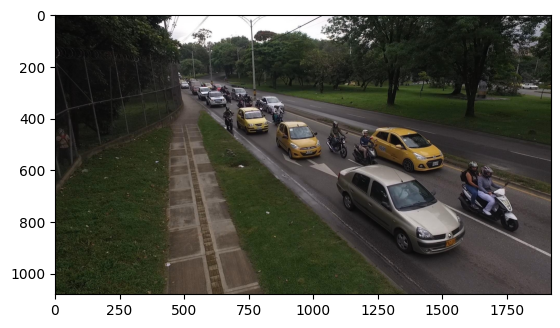

tensor([[1562.,  551., 1794.,  834.],
        [1136.,  427., 1247.,  586.],
        [1045.,  411., 1130.,  553.],
        [ 642.,  350.,  689.,  444.],
        [ 824.,  346.,  889.,  430.]])
tensor([1, 1, 1, 1, 1])


In [ ]:
# Obtener la primera imagen del bach
idx = 1

img = np.transpose(images[idx].numpy(),(1,2,0))

# Moatrar la imagen con plt.show
plt.imshow(img)
plt.show()

# mostrar los boxes
print(boxes[idx])

# mostrar los labels
print(labels[idx])

In [ ]:
# Definir el modelo
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# Reemplazar la capa de salida para el modelo personalizado
num_classes = 2  # background and Motorbike
# obtener el numero de parametros de entrada de la ultima capa
in_features = model.roi_heads.box_predictor.cls_score.in_features
# reemplazar la ultima capa de salida
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
# mover el modelo a la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch.optim as optim
import torchvision.models.detection as detection

# Definir la función de pérdida
def criterion(output, target):
    loss = 0
    loss += F.cross_entropy(output['classification'], target['labels'])
    loss += F.smooth_l1_loss(output['boxes'], target['boxes'])
    return loss

# Definir el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    n = 0
    current_size = len(dataloader)

    for batch_idx, (images, boxes, labels) in enumerate(dataloader):
        # acceder a las imágenes del batch actual
        current_images = images
        # acceder a las etiquetas del batch actual
        current_labels = labels
        # acceder a las cajas delimitadoras del batch actual
        current_boxes = boxes

        # mover los datos al dispositivo
        current_images = [image.to(device) for image in current_images]
        current_labels = [label.to(device) for label in current_labels]
        current_boxes = [{'labels': label.to(device), 'boxes': box.to(device)} for label, box in zip(current_labels, current_boxes)]

        # reiniciar los gradientes del optimizador
        optimizer.zero_grad()

        # hacer una inferencia de los datos con el modelo
        outputs = model(current_images, current_boxes)

        # calcular la pérdida del modelo
        loss_classifier = outputs['loss_classifier']
        loss_box_reg = outputs['loss_box_reg']
        losses = loss_classifier + loss_box_reg
        running_loss += losses.item() * images[0].size(0)
        n += images[0].size(0)



        # realizar la retropropagación y actualizar los parámetros del modelo
        losses.backward()
        optimizer.step()

        if batch_idx % 100==0:
            current_batch = (batch_idx+1)*len(current_images)
            print(f"loss_classifier: {loss_classifier:>5f} loss_box_reg: {loss_box_reg:>5f} [{current_batch:>5d}/{current_size:>d}]")

    # calcular el loss promedio de la época
    epoch_loss = running_loss / n

    return epoch_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    n = 0
    current_size=dataloader

    with torch.no_grad():
        for batch_idx,(images, boxes, labels) in  enumerate(dataloader):
            # acceder a las imágenes del batch actual
            current_images = images
            # acceder a las etiquetas del batch actual
            current_labels = labels
            # acceder a las cajas delimitadoras del batch actual
            current_boxes = boxes

            # mover los datos al dispositivo
            current_images = [image.to(device) for image in current_images]
            current_labels = [label.to(device) for label in current_labels]
            current_boxes = [{'labels': label.to(device), 'boxes': box.to(device)} for label, box in zip(current_labels, current_boxes)]

            # hacer una inferencia de los datos con el modelo
            outputs = model(current_images, current_boxes)
            print("salida",outputs[1])



            # calcular la pérdida del modelo
            #loss_classifier = outputs['loss_classifier']
            #loss_box_reg = outputs['loss_box_reg']
            #losses = loss_classifier + loss_box_reg
            #running_loss += losses.item() * images[0].size(0)
            #n += images[0].size(0)

            # calcular la precisión del modelo

            preds = outputs['labels']
            targets_labels = [t['labels'] for t in current_boxes]
            targets_labels = torch.cat(targets_labels, dim=0)
            running_corrects += torch.sum(preds == targets_labels).item()

            if batch_idx % 100 ==0:
                current_batch = (batch_idx+1)*len(current_images)
                print(f"running_corrects [{current_batch:>5d}/{current_size:>5d}]")

    # calcular el loss y la precisión promedio
    #epoch_loss = running_loss / n
    epoch_acc = running_corrects / n

    return epoch_loss, epoch_acc

In [ ]:
# funcion de entrenamiento para diferentes epocas
import torch.optim as optim
import torch.nn.functional as F

# función para entrenar por varias epochs
def train(model, train_loader,val_loader, optimizer, criterion, device, num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    save_dir = '/content/drive/MyDrive/Model'
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n----------------------------------------------------------")
        # entrenamiento
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print("accuracy of the training \n --------------------------------------------")
        #ret,train_accs = evaluate(model, train_loader, criterion,device)
        # Validacion
        print("Validation \n ----------------------------------------------------------")
        #val_loss,val_accs = evaluate(model, val_loader, criterion,device)

        print('Epoch: {} Train Loss {:.4f}: Train Accuracy:  Val Loss: Val Accuracy:'.format(epoch+1, train_loss))
        train_losses.append(train_loss)
        #train_accs.append(train_acc)
        #val_losses.append(val_loss)
        #val_accs.append(val_acc)

        # Guardar modelo después de cada época
        print("save model \n ----------------------------------------------------------")
        torch.save(model.state_dict(), f'{save_dir}/faster_rcnn_epoch_{epoch+1}.pth')

    return train_losses

In [ ]:
# Ejemplo de uso
num_epochs = 20
model.eval()
train_dataloader
val_dataloader= None
optimizer
criterion = criterion
device = device
model = model.to(device)

In [ ]:
train_losses = train(model, train_dataloader,val_dataloader, optimizer, criterion, device, num_epochs)

Epoch 1
----------------------------------------------------------
loss_classifier: 0.874754 loss_box_reg: 0.232704 [    8/1153]
loss_classifier: 0.030063 loss_box_reg: 0.060264 [  808/1153]
loss_classifier: 0.067828 loss_box_reg: 0.102446 [ 1608/1153]
loss_classifier: 0.064304 loss_box_reg: 0.131915 [ 2408/1153]
loss_classifier: 0.039524 loss_box_reg: 0.114258 [ 3208/1153]
loss_classifier: 0.063634 loss_box_reg: 0.080181 [ 4008/1153]
loss_classifier: 0.066153 loss_box_reg: 0.157259 [ 4808/1153]
loss_classifier: 0.045695 loss_box_reg: 0.085621 [ 5608/1153]
loss_classifier: 0.043541 loss_box_reg: 0.084585 [ 6408/1153]
loss_classifier: 0.038685 loss_box_reg: 0.073768 [ 7208/1153]
loss_classifier: 0.052358 loss_box_reg: 0.114480 [ 8008/1153]
loss_classifier: 0.052389 loss_box_reg: 0.137885 [ 8808/1153]
accuracy of the training 
 --------------------------------------------
Validation 
 ----------------------------------------------------------
Epoch: 1 Train Loss 0.1623: Train Accuracy:  

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Perdida vs el numero de epoch')

In [ ]:
model_path = "/content/drive/MyDrive/Model_faster_RCNN/fasterrcnn_mobilenet_v3_large_320_fpn.pth"

# Definir el modelo
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

# Reemplazar la capa de salida para el modelo personalizado
num_classes = 2  # background and Motorbike
# obtener el numero de parametros de entrada de la ultima capa
in_features = model.roi_heads.box_predictor.cls_score.in_features
# reemplazar la ultima capa de salida
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(model_path))

model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [ ]:
import torchvision.transforms as transfoms
import cv2

img_path = "/content/drive/MyDrive/Yopal (9667).jpg"

# Transformar la imagen de entrada
transform = transforms.Compose([transforms.ToTensor()])
img = cv2.imread(img_path)

print(img.shape)

img_tensor = transform(img).unsqueeze(0)

print(img_tensor.shape)

# Pasar la imagen a traves del modelo
model.eval()
with torch.no_grad():
  outputs = model(img_tensor)

# Interpretar la salida
boxes  = outputs[0]['boxes'].numpy()
labels = outputs[0]['labels'].numpy()
scores = outputs[0]['scores'].numpy()

# Imprimier los rasulatdos
print('Boxes:',boxes)
print('labels:',labels)
print('Scores',scores)

(720, 1280, 3)
torch.Size([1, 3, 720, 1280])
Boxes: [[411.56174 370.0019  621.847   545.69653]
 [108.37847 275.8821  271.98837 420.03006]
 [ 79.96001 411.8902  339.68094 619.78046]
 [394.70856 255.3695  545.92975 393.29785]
 [273.34933 252.12436 372.40402 373.40558]]
labels: [1 1 1 1 1]
Scores [0.9999963  0.99997866 0.999972   0.9999331  0.9227095 ]


tamaño de los datos de salida 5


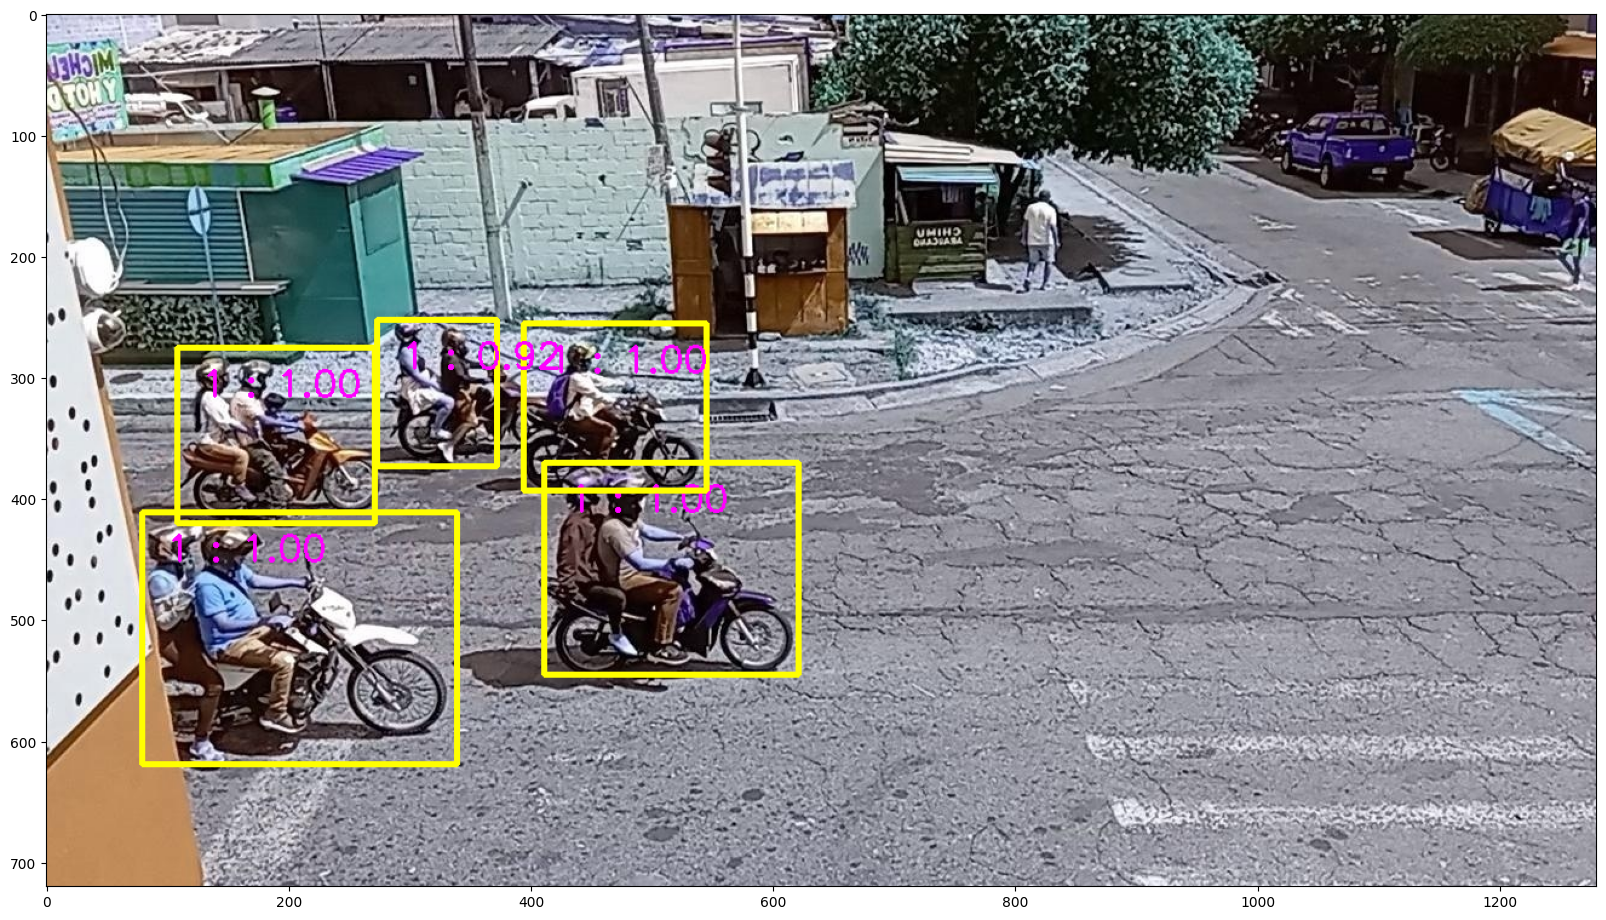

In [ ]:
L= len(boxes)
print("tamaño de los datos de salida",L)

for i in range(L):
  box = boxes[i,:]
  label = f"{labels[i]} : {scores[i]:.2f}"
  cv2.rectangle(img,
                (int(box[0]),int(box[1])),
                (int(box[2]),int(box[3])),
                (255, 255, 0),
                4
                )
  cv2.putText(img, label,
                (int(box[0]) + 20, int(box[1]) + 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,  # font scale
                (255, 0, 255),
                2)  # line type


plt.figure(figsize=(20,15))
plt.imshow(img)
plt.show()

In [ ]:
import torch
import torchvision

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:05<00:00, 14.1MB/s]
